### TF2.0 신경망 만들기
* CNN 신경망 이해
* 고양이와 개의 분류를 CNN을 이용하여 구현해 보기

In [1]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 39kB/s 
     |████████████████████████████████| 4.3MB 42.6MB/s 
     |████████████████████████████████| 501kB 38.5MB/s 


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
print(tf.__version__)

2.0.0-rc1


### 데이터 불러오기
* Kaggle의 필터링 된 버전의 Dogs vs Cats 데이터 세트를 사용

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

```
cats_and_dogs_filtered
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
```

In [13]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(train_dir, validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train /root/.keras/datasets/cats_and_dogs_filtered/validation


In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### 데이터 탐색

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [16]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

### 데이터 준비
* tf.keras에서 제공하는 ImageDataGenerator class
* 디스크에서 이미지를 읽고, 적절한 텐서로 사전 처리가 가능하다.

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

* 이미지 생성기를 정의한 후, flow_from_directory 메서드를 이용
  * 이미지를 로드
  * 이미지의 크기 조정 적용

In [21]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [23]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                   directory=validation_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   class_mode='binary')

Found 1000 images belonging to 2 classes.


### 이미지 추출 후, 이에 대한 시각화

In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

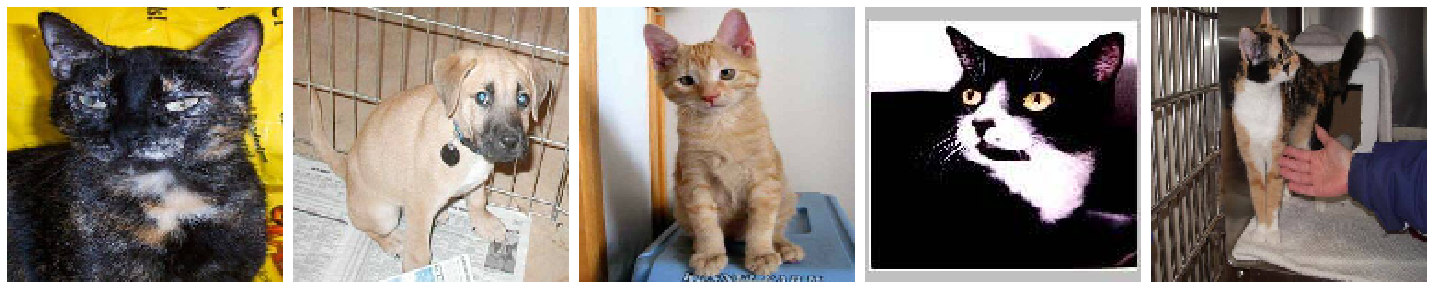

In [26]:
plotImages(sample_training_images[:5])

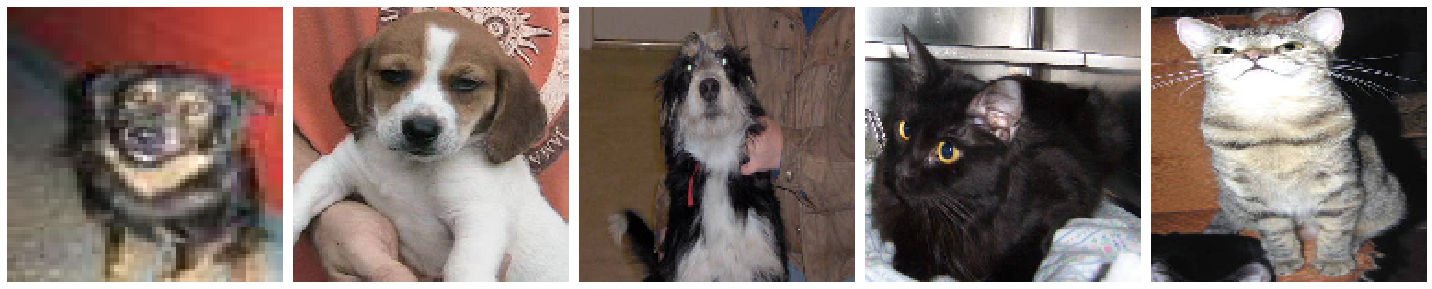

In [27]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

### 모델 만들기(Create the model)
* 개 고양이 분류 : 마지막 뉴런 1개(sigmoid)
* MNIST 분류 : 뉴런 10개(softmax)

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### 모델 컴파일(Compile the model)
* binary_crossentropy : label이 두개
* categorical_crossentropy : label이 여러개

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### 모델 훈련시키기
* ImageDataGenerator의 fit_generator를 사용한다.

In [32]:
%%time

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
15/15 [==============================] - 70s 5s/step - loss: 0.7860 - accuracy: 0.5037 - val_loss: 0.6802 - val_accuracy: 0.5123
Epoch 2/15
15/15 [==============================] - 68s 5s/step - loss: 0.6568 - accuracy: 0.5887 - val_loss: 0.6540 - val_accuracy: 0.6071
Epoch 3/15
15/15 [==============================] - 68s 5s/step - loss: 0.6182 - accuracy: 0.6474 - val_loss: 0.6076 - val_accuracy: 0.6562
Epoch 4/15
15/15 [==============================] - 68s 5s/step - loss: 0.5625 - accuracy: 0.7009 - val_loss: 0.6079 - val_accuracy: 0.6775
Epoch 5/15
15/15 [==============================] - 68s 5s/step - loss: 0.5354 - accuracy: 0.7244 - val_loss: 0.5564 - val_accuracy: 0.7176
Epoch 6/15
15/15 [==============================] - 68s 5s/step - loss: 0.4961 - accuracy: 0.7537 - val_loss: 0.5662 - val_accuracy: 0.7054
Epoch 7/15
15/15 [==============================] - 69s 5s/step - 

### 학습 모델 결과 시각화

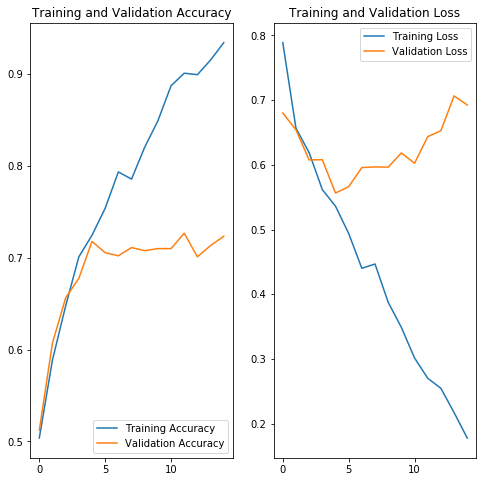

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### REF
* 이미지 분류 : https://www.tensorflow.org/tutorials/images/classification